In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from itertools import product
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

Check for GPU availability

In [25]:
torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [26]:
def preprocess_monk(file_name):
    '''
    function to load data from the monk dataset
    and preproces using one-hot encoding
    '''

    # load the dataset, split into input (X) and output (y) variables
    df = pd.read_csv(file_name, delimiter=' ', header=None, names=['remove_this_column','target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'data_number'], index_col=False)
    df.drop(columns='remove_this_column')

    x1 = np.array(df['x1'])
    x2 = np.array(df['x2'])
    x3 = np.array(df['x3'])
    x4 = np.array(df['x4'])
    x5 = np.array(df['x5'])
    x6 = np.array(df['x6'])
    target = np.array(df['target'])

    encoder = OneHotEncoder(sparse_output=False)

    x1_ =x1.reshape(-1, 1)

    # Fit and transform the data to one-hot encoding
    input_one_hot = encoder.fit_transform(x1_)
    inputs = [x2,x3,x4,x5,x6]

    for x in inputs:
        data =x.reshape(-1, 1)
        # Fit and transform the data to one-hot encoding
        one_hot_encoded = encoder.fit_transform(data)
        input_one_hot = np.hstack((input_one_hot, one_hot_encoded))

    x = torch.tensor(input_one_hot, dtype=torch.float32)#.cuda()
    y = torch.tensor(target, dtype=torch.float32).reshape(-1,1)#.cuda()

    return x, y

Define the model

In [27]:
# Define the classifier
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

# Set hyperparameters
input_size = 17
output_size = 1

In [28]:
def training_model(x_train, y_train, x_test, y_test, hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs=1000, plot_curves=False):
    '''
    function that performs training of the model
    '''

    # Create an instance of the model
    model = SimpleClassifier(input_size, hidden_size, output_size)
    #model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)

    if plot_curves:
        # Lists to store training and test losses for plotting
        train_losses = []
        test_losses = []
        train_accuracies = []
        test_accuracies = []

    # parameters to stop at training convergence
    prev_loss = float('inf')
    patience_counter = 0
    patience = 10

    for epoch in range(num_epochs):
        total_loss = 0.0
        total_accuracy = 0.0
        # Mini-batch training

        model.train()  # Set the model to training mode
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()   # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)   # Compute the loss
            loss.backward() # Backward pass
            optimizer.step()    # Update weights


            prev_loss = loss.item()
            # Accumulate the total loss for this epoch
            total_loss += loss.item()

            # Calculate training accuracy
            predicted_labels = torch.round(outputs)
            correct_predictions = (predicted_labels == labels).sum().item()
            total_samples = labels.size(0)
            total_accuracy += correct_predictions / total_samples

        # Print average training loss and accuracy for the epoch
        average_loss = total_loss / len(train_dataloader)
        average_accuracy = total_accuracy / len(train_dataloader)

        #print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, '
        #      f'Accuracy: {average_accuracy:.4f}')

        if plot_curves:
            train_losses.append(average_loss)
            train_accuracies.append(average_accuracy)

        # Evaluation on the test set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            total_test_loss = 0.0
            total_test_accuracy = 0.0
            for test_inputs, test_labels in test_dataloader:
                test_outputs = model(test_inputs)
                test_loss = criterion(test_outputs, test_labels)
                total_test_loss += test_loss.item()

                # Calculate test accuracy
                predicted_labels = torch.round(test_outputs)
                correct_predictions = (predicted_labels == test_labels).sum().item()
                total_samples = test_labels.size(0)
                total_test_accuracy += correct_predictions / total_samples

            average_test_loss = total_test_loss / len(test_dataloader)
            average_test_accuracy = total_test_accuracy / len(test_dataloader)

            #print(f'Test - Epoch [{epoch+1}/{num_epochs}], Loss: {average_test_loss:.4f},'
            #       f'Accuracy: {average_test_accuracy:.4f}')

            if plot_curves:
                test_accuracies.append(average_test_accuracy)
                test_losses.append(average_test_loss)

        # Check for convergence
        if abs(prev_loss - average_loss) < 1e-3:
            patience_counter += 1
        else:
            patience_counter = 0

        if patience_counter == patience:
        #    print(f"Convergence reached. at epoch {epoch+1} Stopping training.")
            break
        #epochs_reached = epoch+2
        prev_loss = average_loss

    print(f'N. Epochs = {epoch+1} - Loss (train | test)= ({average_loss:.4} | {average_test_loss:.4}) - Accuracy (train | test) = ({average_accuracy} | {average_test_accuracy})')

    if plot_curves:
        # Plot the training and test losses
        plt.figure(figsize=(12, 4))

        # Loss plots
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), train_losses, label='Training Loss')
        plt.plot(range(1, epoch + 2), test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plots
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return epoch+1, average_loss, average_test_loss, average_accuracy, average_test_accuracy

In [29]:
def perform_grid_search_kfold(hidden_sizes, learning_rates, momentums, batch_sizes, reg_coeffs, k_folds, x, y, plot_curves=False):
    '''
    Function that, given the hyperparameters values to explore, performs a grid search with a k fold cross validation
    '''
    best_acc = 0
    best_hyperparams = []

    for hidden_size, learning_rate, momentum, bs, reg_coeff in product(hidden_sizes,learning_rates,momentums,batch_sizes, reg_coeffs):
        print(f'hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}')

        kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and accuracies for each epoch
        train_losses = []
        val_losses = []
        train_acc = []
        val_acc = []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            #print(f"\nFold {fold + 1}/{k_folds}")

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            max_epoch, average_loss, average_val_loss, average_accuracy, average_val_accuracy = training_model(x_train=X_train,
                                                                                                                    y_train=Y_train,
                                                                                                                    x_test=X_val,
                                                                                                                    y_test=Y_val,
                                                                                                                    hidden_size=hidden_size,
                                                                                                                    learning_rate=learning_rate,
                                                                                                                    momentum=momentum,
                                                                                                                    bs = bs,
                                                                                                                    reg_coeff=reg_coeff,
                                                                                                                    plot_curves=plot_curves)

            train_losses.append(average_loss)
            val_losses.append(average_val_loss)
            train_acc.append(average_accuracy)
            val_acc.append(average_val_accuracy)

        print(f'Final Results: hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_acc = {np.mean(train_acc):.4} +- {np.std(train_acc):.4} | '
            f'val_acc = {np.mean(val_acc):.4} +- {np.std(val_acc):.4}')

        if np.mean(val_acc) >= best_acc:
            best_acc = np.mean(val_acc)
            best_hyperparams = [hidden_size, learning_rate, momentum, bs, reg_coeff]

    print(best_hyperparams)
    return best_hyperparams

# Monk 1

In [30]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-1.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-1.test')

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([124, 17])
torch.Size([124, 1])
torch.Size([432, 17])
torch.Size([432, 1])


## Perform Model Selection

In [33]:
hidden_sizes = [5]
learning_rates = [0.2]
momentums = [0.8]
batch_sizes = [8]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.2; alpha = 0.8; batch size = 8; lambda = 0
N. Epochs = 71 - Loss (train | test)= (0.0009505 | 0.003114) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 69 - Loss (train | test)= (0.0006209 | 0.001828) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 57 - Loss (train | test)= (0.0007886 | 0.019) - Accuracy (train | test) = (1.0 | 0.96875)
N. Epochs = 66 - Loss (train | test)= (0.0009839 | 0.0279) - Accuracy (train | test) = (1.0 | 0.9375)


N. Epochs = 45 - Loss (train | test)= (0.001254 | 0.00162) - Accuracy (train | test) = (1.0 | 1.0)


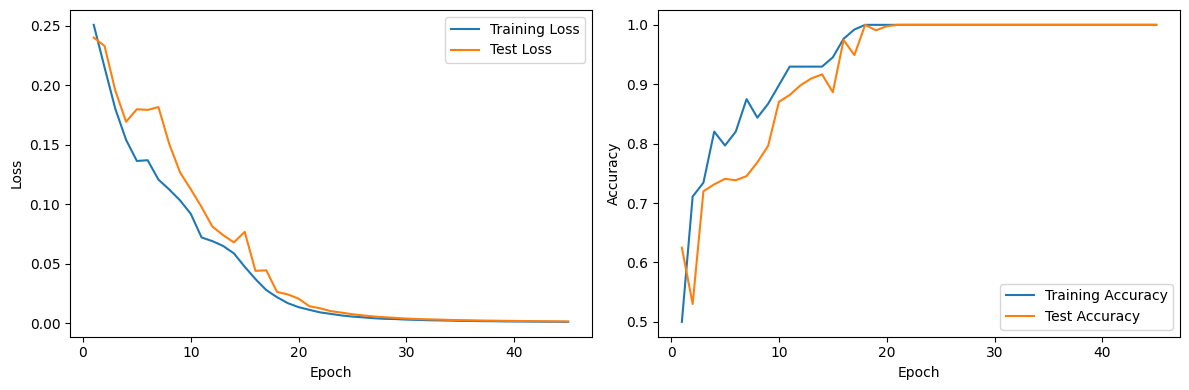

(45, 0.0012543055781861767, 0.001619931398804679, 1.0, 1.0)

In [32]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)